# D210 - Reporting and Representation

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('medical_clean.csv')

In [5]:
df.shape

(10000, 50)

In [6]:
df.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3


# § Data Cleaning  

### ▶ Detection and Treatment of Null Values

In [7]:
df.isnull().sum()

CaseOrder             0
Customer_id           0
Interaction           0
UID                   0
City                  0
State                 0
County                0
Zip                   0
Lat                   0
Lng                   0
Population            0
Area                  0
TimeZone              0
Job                   0
Children              0
Age                   0
Income                0
Marital               0
Gender                0
ReAdmis               0
VitD_levels           0
Doc_visits            0
Full_meals_eaten      0
vitD_supp             0
Soft_drink            0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Services              0
Initial_days          0
TotalCharge           0
Additional_charg

### ▶ Detection and Treatment of Duplicated Values

In [8]:
df.duplicated().value_counts()

False    10000
Name: count, dtype: int64

### ▶ Detection and Treatment of Outliers

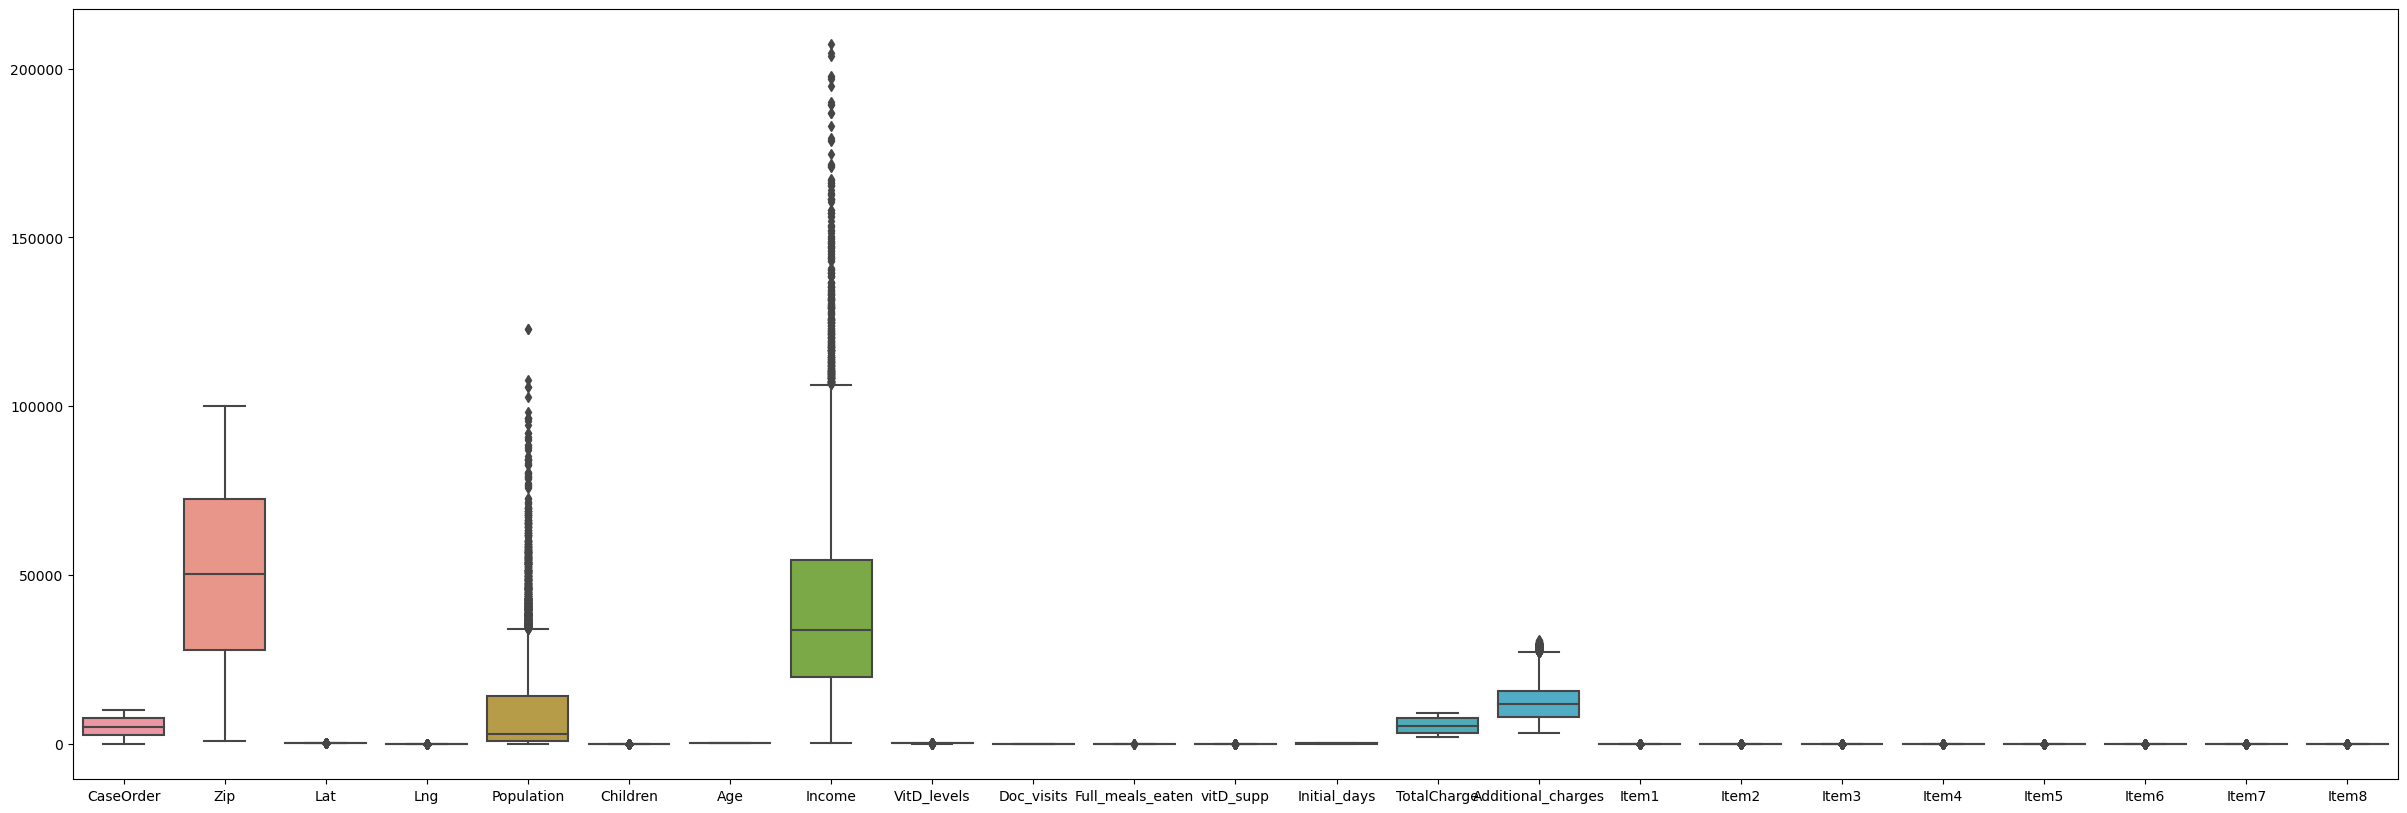

In [13]:
sns.boxplot(df)
fig = plt.gcf()
fig.set_size_inches(30, 10);